In [1]:
from pettingzoo.classic import connect_four_v3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dqn import DQNAgent
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [3]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_epsilon_greedy_action(self, obs):
        obs_mask = obs['action_mask']
        return self.random_choice_with_mask(np.arange(7), obs_mask)

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [4]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_epsilon_greedy_action(self, obs):
        obs_mask = obs['action_mask']
        for i, legal in enumerate(obs_mask):
            if legal:
                return i
        return None


# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [5]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_epsilon_greedy_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_epsilon_greedy_action( obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

In [6]:
def eval(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_epsilon_greedy_action(obs)
            if obs['action_mask'][action] == 0:
                print('Illegal action', action, obs['action_mask'])
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

  0%|          | 0/1500 [00:00<?, ?it/s]/Users/moustaphalo/Documents/RL/Project_RL/dqn.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state).unsqueeze(0).detach()
100%|██████████| 1500/1500 [00:17<00:00, 85.13it/s]


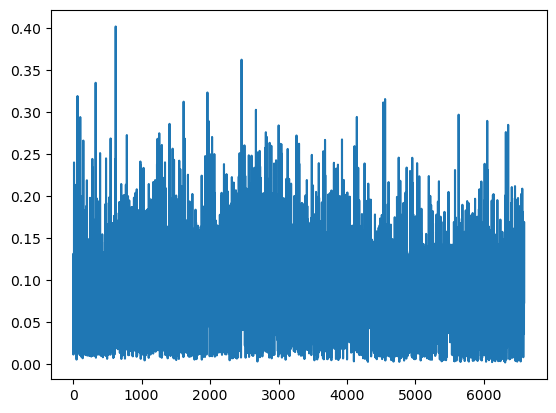

In [7]:
# Define the state space
STATE_SHAPE = (6, 7)

# Define the action space
ACTION_SIZE = 7

env = connect_four_v3.env("render_mode=rgb_array")
agent = DQNAgent(STATE_SHAPE,ACTION_SIZE)

losses = agent.train_env(env,1500, RandomPlayer())
losses2 = agent.train_env(env,1500, PlayLeftmostLegal())
#plt.plot(losses)
plt.plot(losses2)


In [8]:
import time
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        time.sleep(2)
        for i, agent in enumerate([agent0, agent1]):
            #print("legal moves :" ,obs['action_mask'])
            action = agent.get_epsilon_greedy_action( obs)
            #print("action" ,action)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, done, _, _ = env.last()
            print(reward)
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print(obs["action_mask"])
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won with reward {reward}")
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return 1 if agent.name == 'DQN Player' else -1


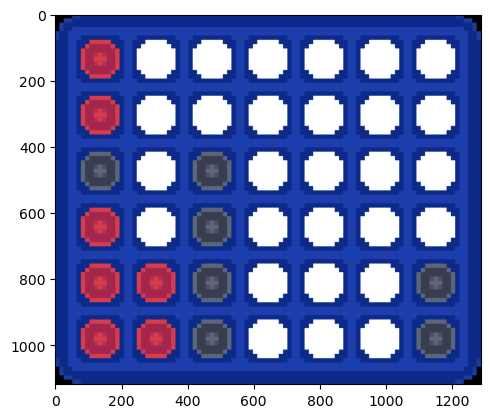

1
Player 1: DQN Player won with reward 1
[[-1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0]
 [-1  0  1  0  0  0  0]
 [-1 -1  1  0  0  0  1]
 [-1 -1  1  0  0  0  1]]


1

In [9]:
env = connect_four_v3.env(render_mode="rgb_array")
play_game(env, PlayLeftmostLegal(),agent,True)

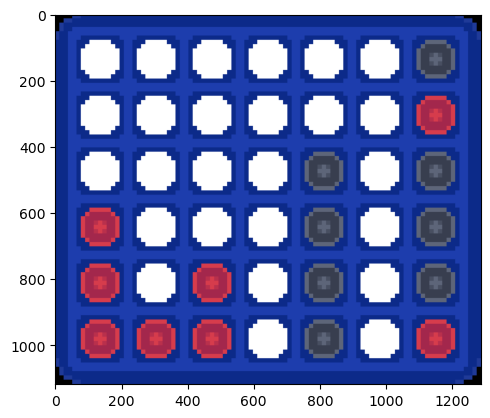

1
Player 1: DQN Player won with reward 1
[[ 0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 -1]
 [ 0  0  0  0  1  0  1]
 [-1  0  0  0  1  0  1]
 [-1  0 -1  0  1  0  1]
 [-1 -1 -1  0  1  0 -1]]


1

In [10]:
play_game(env, RandomPlayer(),agent,True)

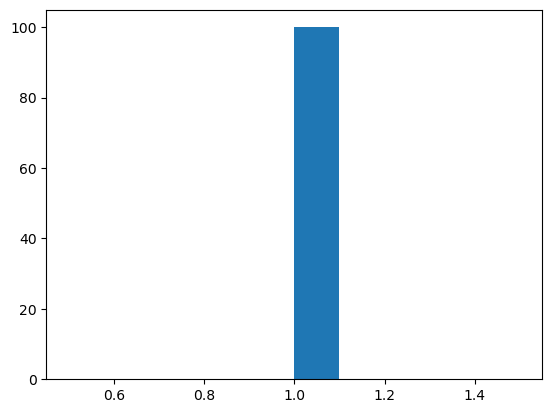

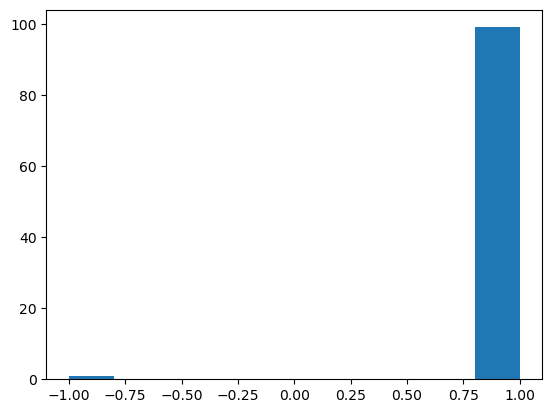

In [11]:
plt.hist(eval(env, agent, PlayLeftmostLegal(), N_episodes=100, first_player=False))
plt.show()
plt.hist(eval(env, agent, PlayLeftmostLegal(), N_episodes=100, first_player=True))
plt.show()

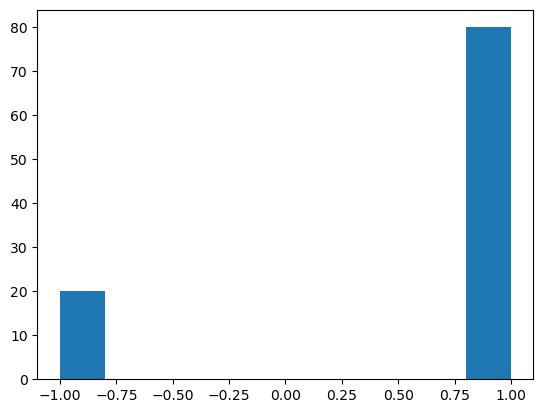

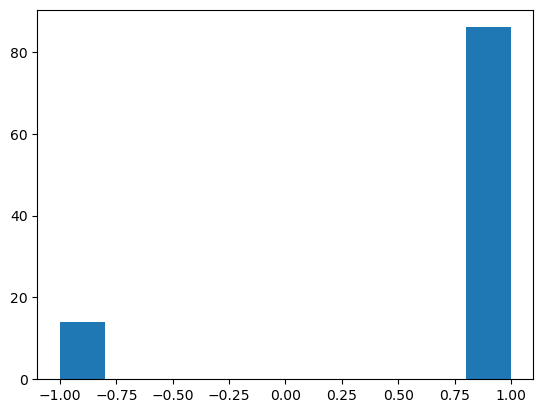

In [12]:
plt.hist(eval(env, agent, RandomPlayer(), N_episodes=100, first_player=False))
plt.show()
plt.hist(eval(env, agent, RandomPlayer(), N_episodes=100, first_player=True))
plt.show()